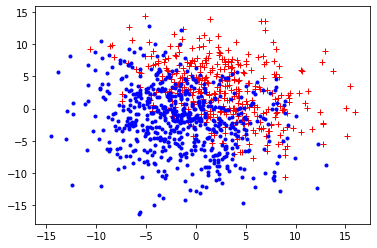

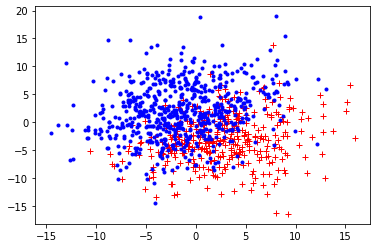

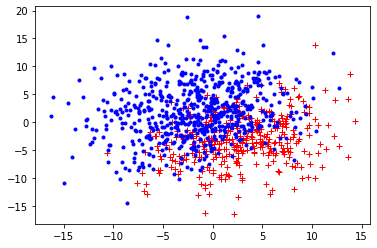

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#sample
npoints=1000
#define points
x1 = np.random.normal(0, 5, npoints) #mean, sigma, num_points
x2 = np.random.normal(0, 5, npoints)
x3 = np.random.normal(0, 5, npoints)

#make a discriminator between two samples that is largely y-based (small x-y slope)
mask_pos = x2 >  (3. - x1+x3)
mask_neg = x2 <= (3. - x1+x3)

#now smear
noise = 1.0 #sets the noise scale
x1noise = np.random.normal(0, noise, npoints)
x2noise = np.random.normal(0, noise, npoints)
x3noise = np.random.normal(0, noise, npoints)
x1 = x1 + x1noise
x2 = x2 + x2noise
x3 = x3 + x3noise

# lets define a true boundary between the two classes
x1_pos = x1[mask_pos]
x2_pos = x2[mask_pos]
x3_pos = x3[mask_pos]
x1_neg = x1[mask_neg]
x2_neg = x2[mask_neg]
x3_neg = x3[mask_neg]

#plot the lot
plt.plot(x1_pos, x2_pos, 'r+')
plt.plot(x1_neg, x2_neg, 'b.')
x_list = [np.concatenate((x1_pos,x1_neg)),np.concatenate((x2_pos,x2_neg)),np.concatenate((x3_pos,x3_neg))]
y_list = [1.]*len(x1_pos) + [-1.]*len(x1_neg)
#y_list = [1.]*len(x1_pos) + [0]*len(x1_neg)
plt.show()

plt.plot(x1_pos, x3_pos, 'r+')
plt.plot(x1_neg, x3_neg, 'b.')
plt.show()

plt.plot(x2_pos, x3_pos, 'r+')
plt.plot(x2_neg, x3_neg, 'b.')
plt.show()

In [2]:
#now lets separate these guys with an NN to start with
import torch 

class simple_MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(3,16)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(16,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x
    

simple_model = simple_MLP()
#print(simple_model.state_dict())


[1] loss: 0.1364  
[2] loss: 0.1357  
[3] loss: 0.1352  
[4] loss: 0.1347  
[5] loss: 0.1342  
[6] loss: 0.1338  
[7] loss: 0.1334  
[8] loss: 0.1330  
[9] loss: 0.1326  
[10] loss: 0.1323  
[11] loss: 0.1320  
[12] loss: 0.1317  
[13] loss: 0.1314  
[14] loss: 0.1312  
[15] loss: 0.1310  
[16] loss: 0.1307  
[17] loss: 0.1305  
[18] loss: 0.1302  
[19] loss: 0.1300  
[20] loss: 0.1298  
[21] loss: 0.1296  
[22] loss: 0.1294  
[23] loss: 0.1292  
[24] loss: 0.1289  
[25] loss: 0.1288  
[26] loss: 0.1286  
[27] loss: 0.1283  
[28] loss: 0.1281  
[29] loss: 0.1279  
[30] loss: 0.1277  
[31] loss: 0.1275  
[32] loss: 0.1274  
[33] loss: 0.1272  
[34] loss: 0.1270  
[35] loss: 0.1268  
[36] loss: 0.1266  
[37] loss: 0.1264  
[38] loss: 0.1263  
[39] loss: 0.1261  
[40] loss: 0.1259  
[41] loss: 0.1258  
[42] loss: 0.1256  
[43] loss: 0.1254  
[44] loss: 0.1252  
[45] loss: 0.1250  
[46] loss: 0.1248  
[47] loss: 0.1246  
[48] loss: 0.1244  
[49] loss: 0.1243  
[50] loss: 0.1242  
[51] loss

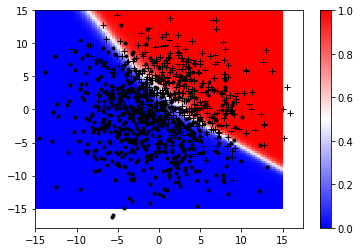

In [5]:
#Loss (Binary croos entry)
simple_criterion = torch.nn.BCELoss()
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.01) 
simple_history = {'loss':[]}

#formatting crap 
x_list_np = np.transpose(np.vstack((x_list[0],x_list[1],x_list[2])))
y_list_np = (np.array(y_list)+1)/2
x_torch=torch.from_numpy(x_list_np).float()
y_torch=torch.from_numpy(y_list_np.reshape(npoints,1)).float()

for epoch in range(100):
    simple_optimizer.zero_grad()
    outputs = simple_model(x_torch)
    loss = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))
    simple_history['loss'].append(current_loss)

outputs_optimal = simple_model(x_torch)
print('Finished Training')

#Now plot its perofmrance on a grid
x1_list = np.linspace(-15., 15., 100)
x2_list = np.linspace(-15., 15., 100)
x1_grid, x2_grid  = np.meshgrid(x1_list, x2_list)
x3_list = np.zeros(len(x2_grid.flatten()))
x_grid_np = np.transpose(np.vstack((x1_grid.flatten(),x2_grid.flatten(),x3_list)))
#x_grid_np = np.transpose(np.vstack((x1_grid.flatten(),x2_grid,x3_list)))
x_torch=torch.from_numpy(x_grid_np).float()
h_grid = simple_model(x_torch)
h_grid=h_grid.detach().numpy()
h_grid=h_grid.reshape(100,100)
plt.pcolormesh(x1_grid, x2_grid, h_grid, cmap = 'bwr', shading='auto')
plt.colorbar()

#now pot the points
plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')

plt.show()

[1] loss: 0.6824  
[2] loss: 0.6268  
[3] loss: 0.5784  
[4] loss: 0.5372  
[5] loss: 0.5032  
[6] loss: 0.4760  
[7] loss: 0.4556  
[8] loss: 0.4414  
[9] loss: 0.4325  
[10] loss: 0.4280  
[11] loss: 0.4264  
[12] loss: 0.4266  
[13] loss: 0.4275  
[14] loss: 0.4285  
[15] loss: 0.4293  
[16] loss: 0.4299  
[17] loss: 0.4301  
[18] loss: 0.4302  
[19] loss: 0.4303  
[20] loss: 0.4304  
[21] loss: 0.4304  
[22] loss: 0.4304  
[23] loss: 0.4303  
[24] loss: 0.4300  
[25] loss: 0.4295  
[26] loss: 0.4288  
[27] loss: 0.4279  
[28] loss: 0.4269  
[29] loss: 0.4258  
[30] loss: 0.4247  
[31] loss: 0.4236  
[32] loss: 0.4226  
[33] loss: 0.4217  
[34] loss: 0.4210  
[35] loss: 0.4206  
[36] loss: 0.4202  
[37] loss: 0.4200  
[38] loss: 0.4199  
[39] loss: 0.4199  
[40] loss: 0.4199  
[41] loss: 0.4199  
[42] loss: 0.4198  
[43] loss: 0.4198  
[44] loss: 0.4197  
[45] loss: 0.4197  
[46] loss: 0.4196  
[47] loss: 0.4196  
[48] loss: 0.4195  
[49] loss: 0.4195  
[50] loss: 0.4194  
[51] loss

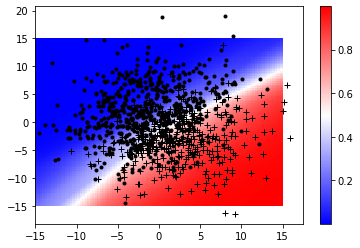

In [4]:
class simple_MLP_N1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2,16)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(16,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

simple_model_n1 = simple_MLP_N1()

#Loss (Binary croos entry)
simple_criterion = torch.nn.BCELoss()
simple_optimizer = torch.optim.Adam(simple_model_n1.parameters(), lr=0.01) 
simple_history = {'loss':[]}

#formatting crap 
x_list_np = np.transpose(np.vstack((x_list[0],x_list[2])))
y_list_np = (np.array(y_list)+1)/2
x_torch=torch.from_numpy(x_list_np).float()
y_torch=torch.from_numpy(y_list_np.reshape(npoints,1)).float()

#train
for epoch in range(100):
    simple_optimizer.zero_grad()
    outputs = simple_model_n1(x_torch)
    loss = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))
    simple_history['loss'].append(current_loss)

outputs_optimal_n1 = simple_model_n1(x_torch)
print('Finished Training')
#torch.save(simple_model.state_dict(), 'simple_model.pt')
#print(simple_model.state_dict())

#Now plot its perofmrance on a grid
x1_list = np.linspace(-15., 15., 100)
x3_list = np.linspace(-15., 15., 100)
x1_grid, x3_grid  = np.meshgrid(x1_list, x3_list)
x_grid_np = np.transpose(np.vstack((x1_grid.flatten(),x3_grid.flatten())))
#x_grid_np = np.transpose(np.vstack((x1_grid.flatten(),x2_grid,x3_list)))
x_torch=torch.from_numpy(x_grid_np).float()
h_grid = simple_model_n1(x_torch)
h_grid=h_grid.detach().numpy()
h_grid=h_grid.reshape(100,100)
plt.pcolormesh(x1_grid, x3_grid, h_grid, cmap = 'bwr', shading='auto')
plt.colorbar()

#now pot the points
plt.plot(x1_pos, x3_pos, 'k+')
plt.plot(x1_neg, x3_neg, 'k.')

plt.show()

In [6]:
import torch.nn as nn

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        #print((mask*log_prob).sum(1))
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        
        return loss

In [7]:
#using some random library
from fast_soft_sort.pytorch_ops import soft_rank
#import torchsort

#some failed attempts first
def corrcoef(target, pred):
    # np.corrcoef in torch from @mdo
    # https://forum.numer.ai/t/custom-loss-functions-for-xgboost-using-pytorch/960
    pred_n = pred - pred.mean()
    target_n = target - target.mean()
    pred_n = pred_n / pred_n.norm()
    target_n = target_n / target_n.norm()
    return (pred_n * target_n).sum()


def spearman(target,pred,regularization="l2",regularization_strength=1.0,):
    # fast_soft_sort uses 1-based indexing, divide by len to compute percentage of rank
    pred = soft_rank(pred,regularization=regularization,regularization_strength=regularization_strength,)
    return corrcoef(target, pred / pred.shape[-1])


def spearman_loss_lgb(ytrue, ypred):
    
    def corrcoef(target, pred):
        pred_n = pred - pred.mean()
        target_n = target - target.mean()
        pred_n = pred_n / pred_n.norm()
        target_n = target_n / target_n.norm()
        return (pred_n * target_n).sum()

    def differentiable_spearman(target, pred, regularization="l2", regularization_strength=1.0,):
        pred = soft_rank(pred,regularization=regularization,regularization_strength=regularization_strength,)
        return corrcoef(target, pred / pred.shape[-1])
    
    lenypred = ypred.shape[0]
    lenytrue = ytrue.shape[0]

    ypred_th = torch.tensor(ypred.reshape(1, lenypred), requires_grad=True)
    ytrue_th = torch.tensor(ytrue.reshape(1, lenytrue))

    loss = differentiable_spearman(ytrue_th, ypred_th, regularization_strength=1e-2)
    print(f'Current loss:{loss}')
    return 

    # calculate gradient and convert to numpy
    #loss_grads = torch.autograd.grad(loss, ypred_th)[0]
    #loss_grads = loss_grads.to('cpu').detach().numpy()

    # return gradient and ones instead of Hessian diagonal
    #return loss_grads[0], np.ones(loss_grads.shape)[0]
    
#now the final correlation loss    
class CorrLoss(nn.Module):
    def __init__(self, sort_tolerance=1.0,sort_reg='l2'):
        super(CorrLoss, self).__init__()
        self.tolerance = sort_tolerance
        self.reg       = sort_reg
        
    def spearman(self, pred, target):
        pred   = soft_rank(pred.reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        target = soft_rank(target.reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        #pred   = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
        #target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
        pred = pred - pred.mean()
        pred = pred / pred.norm()
        target = target - target.mean()
        target = target / target.norm()
        ret = (pred * target).sum()
        return ret*ret
    
    def forward(self, features, labels):
        return self.spearman(features,labels)                   

In [8]:
class CorrLoss2(nn.Module):
    def __init__(self,background_only=False,background_label=1,power=2):
        self.backonly = background_only
        self.background_label = background_label
        self.power = power

    def distance_corr(self,var_1,var_2,normedweight,power=1):
        xx = var_1.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))
        #yy = var_1.            expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))
        #print(xx,yy)
        amat = (xx).abs()
        del xx
        amatavg = torch.mean(amat*normedweight,dim=1)
        Amat=amat-amatavg.expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))\
            -amatavg.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))\
            +torch.mean(amatavg*normedweight)
        del amat
        #print("Amat",Amat)
        
        xx = var_2.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))
        #yy = var_2.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))
        bmat = (xx).abs()
        del xx

        bmatavg = torch.mean(bmat*normedweight,dim=1)
        Bmat=bmat-bmatavg.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))\
            -bmatavg.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))\
            +torch.mean(bmatavg*normedweight)
        del bmat
        #print("bmat",Bmat)

        ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
        AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
        BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)
        del Bmat, Amat

        if(power==1):
            dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
        elif(power==2):
            dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
        else:
            dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power

        return dCorr

    def __call__(self,pred,x_biased,weights=None):
        #if self.backonly:
        #    mask = target==self.background_label
        #    x_biased = x_biased[mask]
        #    pred = pred[mask]
        #    target = target[mask]
        #if weights is not None:
        #    weights =  weights[mask]
        #else:
        xweights = torch.ones_like(pred)
        #del mask
        disco = self.distance_corr(x_biased,pred,normedweight=xweights,power=self.power)
        return disco


In [9]:
#skip this box
class simple_CLR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(3,16)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(16,16)
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(16,2)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        #x = self.output(x)
        return x
    

simple_clr = simple_CLR()
#rint(simple_clr.state_dict())

In [12]:
#skip this box
simple_criterion = SupConLoss()
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.01) 
simple_history = {'loss':[]}
x_list_np = np.transpose(np.vstack((x_list[0],x_list[1],x_list[2])))
y_list_np = (np.array(y_list)+1)/2
x_list_np = np.reshape(x_list_np,(npoints,1,3))
x_torch=torch.from_numpy(x_list_np).float()
y_torch=torch.from_numpy(y_list_np.reshape(npoints,1)).float()
#print(x1_pos[0],x2_pos[0],x_torch[0][0],x_torch[0][1],y_torch[0])
for epoch in range(100):
    simple_optimizer.zero_grad()
    outputs = simple_clr(x_torch)
    loss = simple_criterion(outputs,y_torch)
    loss.backward()
    simple_optimizer.step()    
    current_loss = loss.item()
    if epoch % 10 == 0: 
        print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))
    simple_history['loss'].append(current_loss)
            
print('Finished Training')
#torch.save(simple_clr.state_dict(), 'simple_model.pt')
#print(simple_clr.state_dict())

[1] loss: 36.8753  
[11] loss: 36.8753  
[21] loss: 36.8753  
[31] loss: 36.8753  
[41] loss: 36.8753  
[51] loss: 36.8753  
[61] loss: 36.8753  
[71] loss: 36.8753  
[81] loss: 36.8753  
[91] loss: 36.8753  
Finished Training


(10000,)


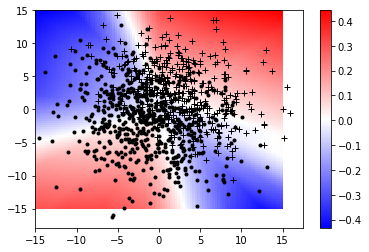

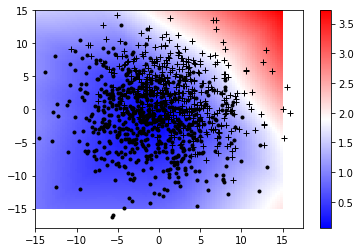

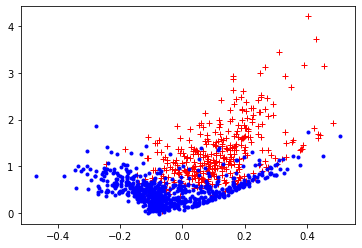

In [15]:
#this box plotting a working contrastive learning from above (skipped for now)
x_torch=torch.from_numpy(x_grid_np).float()
h_grid = simple_clr(x_torch)
h_grid=h_grid.detach().numpy()
print(h_grid[:,0].shape)
h_gridx=h_grid[:,0].reshape(100,100)
plt.pcolormesh(x1_grid, x2_grid, h_gridx, cmap = 'bwr', shading='auto')
plt.colorbar()
plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')
plt.show()

h_gridy=h_grid[:,1].reshape(100,100)
plt.pcolormesh(x1_grid, x2_grid, h_gridy, cmap = 'bwr', shading='auto')
plt.colorbar()
plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')
plt.show()

x_torch=torch.from_numpy(x_list_np).float()
outputs = simple_clr(x_torch)
plt.plot(outputs[y_torch > 0][:,0].detach().numpy(),outputs[y_torch > 0][:,1].detach().numpy(),  'k+',c='r')
plt.plot(outputs[y_torch == 0][:,0].detach().numpy(),outputs[y_torch == 0][:,1].detach().numpy(),'k.',c='b')
plt.show()


In [55]:
class test_CLR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        nhidden=64
        self.fc1 = torch.nn.Linear(3,nhidden)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(nhidden,nhidden)
        self.ac2 = torch.nn.ReLU()
        self.btchnorm = torch.nn.LazyBatchNorm1d()
        self.fc3 = torch.nn.Linear(nhidden,2)
        self.output = torch.nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        #x = self.fc2(x)
        #x = self.ac2(x)
        #x = self.btchnorm(x)
        x = self.fc3(x)
        #x = self.output(x)
        return x

test_clr = test_CLR()

/Users/pharris/Library/Python/3.7/lib/python/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
class simple_tran_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1,16)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(16,16)
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(16,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.output(x)
        return x
    

simple_tran      = simple_tran_model()
simple_criterion = torch.nn.BCELoss()
disc_optimizer   = torch.optim.Adam(simple_tran.parameters(), lr=0.001) 
mass_list_np     = x_list[1].reshape(1000,1)
y_list_np = (np.array(y_list)+1)/2
mass_torch=torch.from_numpy(mass_list_np).float()
y_torch=torch.from_numpy(y_list_np.reshape(npoints,1)).float()
for epoch in range(1000):
    disc_optimizer.zero_grad()
    outputs     = simple_tran(mass_torch)
    loss_bce    = simple_criterion(outputs,y_torch)
    loss        = loss_bce
    loss.backward()
    disc_optimizer.step()
    current_loss = loss.item()
    if epoch % 100 == 0: 
        print('[%d] loss: %.4f ' % (epoch + 1,  current_loss))

mass_tran = simple_tran(mass_torch)
#print(mass_tran.detach().numpy()[:,0])

[1] loss: 0.8066 
[101] loss: 0.5682 
[201] loss: 0.5494 
[301] loss: 0.5490 
[401] loss: 0.5487 
[501] loss: 0.5484 
[601] loss: 0.5482 
[701] loss: 0.5480 
[801] loss: 0.5478 
[901] loss: 0.5477 


In [56]:
clr_criterion  = SupConLoss()
mse_criterion  = nn.MSELoss()
cor_criterion  = CorrLoss()
cor_criterion2 = CorrLoss2()
test_optimizer = torch.optim.Adam(test_clr.parameters(), lr=0.01) 
test_history = {'loss':[]}

#py torch stuff
x_list_np = np.transpose(np.vstack((x_list[0],x_list[1],x_list[2])))
#x_list_np = np.transpose(np.vstack((x_list[0],mass_tran.detach().numpy()[:,0],x_list[2])))
y_list_np = (np.array(y_list)+1)/2
x_list_np = np.reshape(x_list_np,(npoints,1,3))
x_torch=torch.from_numpy(x_list_np).float()
x_torch=(x_torch) / np.sqrt(x_torch.var())
y_torch=torch.from_numpy(y_list_np.reshape(npoints,1)).float()
bkg_mask=(y_torch==0)
#training 
for epoch in range(100):
    test_optimizer.zero_grad()
    outputs     = test_clr(x_torch)
    loss_clr    = clr_criterion(outputs,y_torch)
    loss_mse    = mse_criterion(outputs[:,:,1:2],x_torch[:,:,1:2])
    #loss_mse    = 10*(loss_mse.mean())#*bkg_mask.float()).mean()
    #xtest=outputs[:,:,0:1].reshape(len(outputs),1)
    #ytest=outputs[:,:,1:2].reshape(len(outputs),1)
    #loss_corr   = cor_criterion2(xtest,ytest)
    #loss_corr   =  cor_criterion(outputs[:,:,0:1],x_torch[:,:,1:2])
    #loss_corr   = 10*(loss_corr.mean())#*bkg_mask.float()).mean()
    loss_corr = cor_criterion(outputs[:,:,0:1],outputs[:,:,1:2])    
    loss = loss_clr+loss_mse+loss_corr#+loss_decorr
    loss.backward()
    test_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    clr_loss  = loss_clr.item()
    mse_loss  = loss_mse.item()
    corr_loss = loss_corr.item() 
    decorr_loss = 0#loss_decorr.item() 
    corr2_loss  = 0#loss_corr2.item() 
    if epoch % 10 == 0: 
        print('[%d] loss: %.4f %.4f %.4f %.4f %.4f %.4f' % (epoch + 1,  current_loss, clr_loss, mse_loss, corr_loss,decorr_loss,corr2_loss))
    test_history['loss'].append(current_loss)
            
print('Finished Training')


[1] loss: 8.1628 7.1140 1.0436 0.0052 0.0000 0.0000
[11] loss: 7.5617 6.8155 0.6716 0.0746 0.0000 0.0000
[21] loss: 7.4877 6.8354 0.6507 0.0016 0.0000 0.0000
[31] loss: 7.4204 6.7168 0.7034 0.0002 0.0000 0.0000
[41] loss: 7.3850 6.6884 0.6941 0.0025 0.0000 0.0000
[51] loss: 7.3544 6.6531 0.7009 0.0004 0.0000 0.0000
[61] loss: 7.3359 6.6249 0.7096 0.0014 0.0000 0.0000
[71] loss: 7.3226 6.6122 0.7088 0.0016 0.0000 0.0000
[81] loss: 7.3097 6.6019 0.7067 0.0011 0.0000 0.0000
[91] loss: 7.3055 6.6008 0.7001 0.0046 0.0000 0.0000
Finished Training


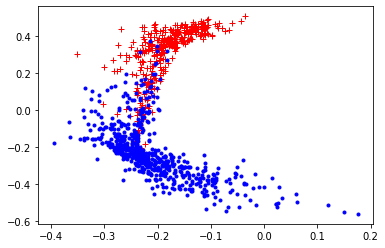

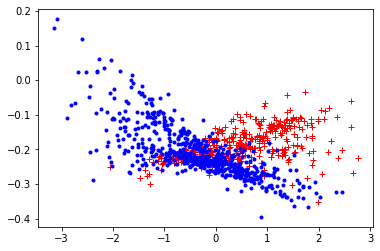

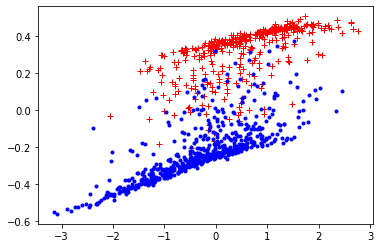

NameError: name 'mass_torch' is not defined

In [57]:
#now we plot it
#x_torch=torch.from_numpy(x_list_np).float()
#x_torch=(x_torch - x_torch.mean()) / np.sqrt(x_torch.var())
outputs = test_clr(x_torch)

#This is the output space split by type
plt.plot(outputs[y_torch > 0][:,0].detach().numpy(),outputs[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.show()

#This plot should NOT be correlated
plt.plot(x_torch[y_torch > 0][:,1].detach().numpy(),outputs[y_torch > 0][:,0].detach().numpy(), 'k+',c='r')
plt.plot(x_torch[y_torch == 0][:,1].detach().numpy(),outputs[y_torch == 0][:,0].detach().numpy(), 'k.',c='b')
plt.show()

#This plot should be correlated
plt.plot(x_torch[y_torch > 0][:,1].detach().numpy(),outputs[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.plot(x_torch[y_torch == 0][:,1].detach().numpy(),outputs[y_torch == 0][:,1].detach().numpy(), 'k.',c='b')
plt.show()

#This plot should NOT be correlated
plt.plot(mass_torch[y_torch > 0],outputs[y_torch > 0][:,0].detach().numpy(), 'k+',c='r')
plt.plot(mass_torch[y_torch == 0],outputs[y_torch == 0][:,0].detach().numpy(), 'k.',c='b')
plt.show()

#This plot should be correlated
plt.plot(mass_torch[y_torch > 0],outputs[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.plot(mass_torch[y_torch == 0],outputs[y_torch == 0][:,1].detach().numpy(), 'k.',c='b')
plt.show()


In [40]:
#finally lets check it all
def compute_ROC(labels, predicts, npts=1001):
    lMin = np.min(predicts)
    lMax = np.max(predicts)
    cutvals = np.linspace(lMin,lMax,num=npts)
    tot0 = float(len(labels[labels==0]))
    tot1 = float(len(labels[labels==1]))
    tpr = []
    fpr = []
    for c in cutvals:
        fpr.append(float(len(predicts[(labels==0) & (predicts>c)]))/tot0)
        tpr.append(float(len(predicts[(labels==1) & (predicts>c)]))/tot1)
    
    return np.array(fpr),np.array(tpr)

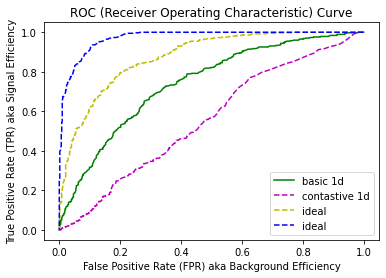

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve

#fpr_1d,  tpr_1d,  cuts = roc_curve(y_score=x_torch[:,:,0].detach().numpy().flatten(), y_true=y_list_np)
#fpr_1dc, tpr_1dc, cuts = roc_curve(y_score=outputs[:,:,0].detach().numpy().flatten(), y_true=y_list_np)

roc_1d          = compute_ROC(y_list_np,x_torch[:,:,0].detach().numpy().flatten())
roc_1d_contrast = compute_ROC(y_list_np,-1*outputs[:,:,0].detach().numpy().flatten())
outputs_optimal = simple_model(x_torch)
roc_ideal       = compute_ROC(y_list_np,outputs_optimal_n1.detach().numpy().flatten())
roc_ideal_full  = compute_ROC(y_list_np,outputs_optimal.detach().numpy().flatten())

plt.plot(roc_1d[0],         roc_1d[1],'g-',label="basic 1d")
plt.plot(roc_1d_contrast[0],roc_1d_contrast[1],'m--',label="contastive 1d")
plt.plot(roc_ideal[0],      roc_ideal[1],'y--',label="ideal")
plt.plot(roc_ideal_full[0], roc_ideal_full[1],'b--',label="ideal")


plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()